## Predição de rotatividade de clientes com Ciência de Dados

Este projeto tem o objetivo de prever a rotatividade de consumidores a partir de informações pessoais, de pagamentos e serviços contratados. A *rotatividade* em questão é a análise dos consumidores com intenção de parar de adquirir os serviços (ou seja, "deixar" a empresa).

**Integrantes:**
- André Luís Mendes Fakhoury
- Gustavo Vinícius Vieira Silva Soares
- Thiago Preischadt Pinheiro

**Prof.** Francisco Aparecido Rodrigues

<center>
USP - ICMC - 2021
</center>

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns

## Preparação dos Dados

Nessa etapa, os dados serão preparados com o objetivo de prepará-los para etapas posteriores do projeto. Será feita a limpeza de dados utilizando métodos de transformação de dados e pré-processamento.

In [160]:
df = pd.read_csv('churn.csv')
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


Primeiramente, pode-se remover a coluna de "customerID", pois não terá importância para as próximas etapas. Antes disso, é possível verificar se existem campos duplicados, pois trata-se de um campo identificador único do cliente.

In [161]:
df['customerID'].duplicated().any()

False

O campo customerId não tem elementos repetidos, portanto pode-se removê-lo.

In [162]:
df.drop(columns=['customerID'], inplace=True)

Outro tratamento a se realizar é a transformação do campo "TotalCharges" para *float*. Porém, para isso, é necessário tratar alguns de seus valores, que possuem a string vazia ' '. Esses valores são então substituídos para uma aproximação, calculada pelo respectivo campo "MonthlyCharges" multiplicado pelo "tenure".

In [164]:
mask = df['TotalCharges'] == ' '
df.loc[mask, 'TotalCharges'] = df.loc[mask, 'MonthlyCharges'] * df.loc[mask, 'tenure']
df['TotalCharges'] = df['TotalCharges'].astype(float)

## Análise Exploratória de Dados

Nessa etapa, os dados serão analisados a partir de medidas estatísticas, e visualizados de forma gráfica, com o objetivo de verificar como eles estão dispostos no *dataset* e como se relacionam com outros dados.

In [165]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


<AxesSubplot:xlabel='Churn', ylabel='count'>

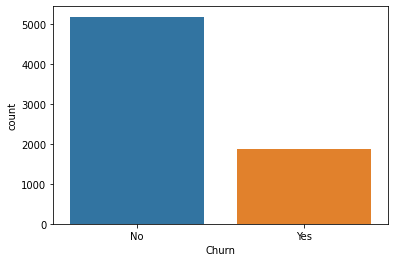

In [166]:
sns.countplot(x='Churn', data=df)

<AxesSubplot:xlabel='gender', ylabel='count'>

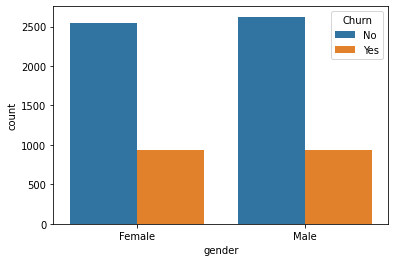

In [167]:
sns.countplot(x='gender', hue='Churn', data=df)

<AxesSubplot:xlabel='InternetService', ylabel='count'>

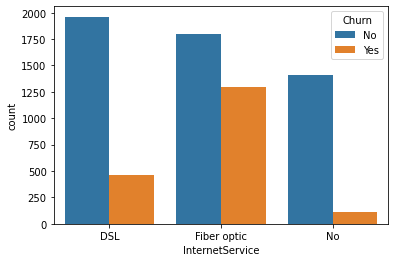

In [168]:
sns.countplot(x='InternetService', hue='Churn', data=df)

<AxesSubplot:xlabel='PhoneService', ylabel='count'>

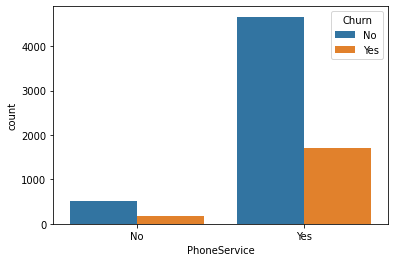

In [169]:
sns.countplot(x='PhoneService', hue='Churn', data=df)

<AxesSubplot:>

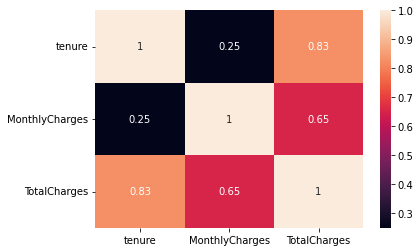

In [172]:
sns.heatmap(df[['tenure', 'MonthlyCharges', 'TotalCharges']].corr(), annot=True)

In [174]:
(df['TotalCharges'] - df['MonthlyCharges'] * df['tenure']).mean()

0.1529532869515806

<AxesSubplot:xlabel='MonthlyCharges', ylabel='Count'>

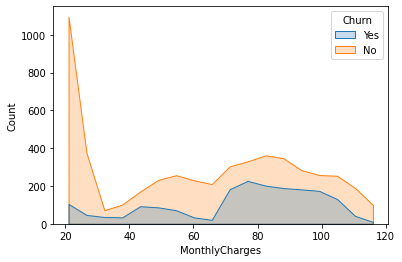

In [171]:
sns.histplot(df, x='MonthlyCharges', hue='Churn', hue_order=['Yes', 'No'], element='poly')

<AxesSubplot:xlabel='TotalCharges', ylabel='Count'>

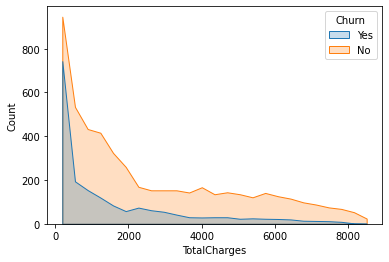

In [129]:
sns.histplot(df, x='TotalCharges', hue='Churn', hue_order=['Yes', 'No'], element='poly')

<AxesSubplot:xlabel='tenure', ylabel='Count'>

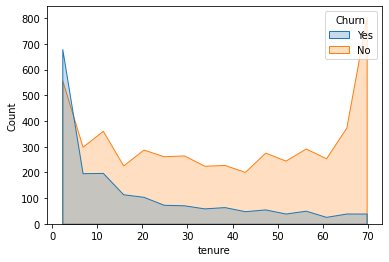

In [128]:
sns.histplot(df, x='tenure', hue='Churn', hue_order=['Yes', 'No'], element='poly')

## Treinamento e Utilização dos Modelos

deixa valores das colunas com "yes" e "no" em 1 e 0, e genero masculino->0 e feminino->1

In [104]:
for col in ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']:
    df[col] = df[col].map(lambda x: int(x == 'Yes'))
df['gender'] = df['gender'].map(lambda x: int(x == 'Female'))

faz o OneHot Encoding das colunas internetService, contract e paymentMethod

In [95]:
df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'])
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
1,0,0,0,0,34,1,0,1,0,1,...,1,0,0,0,1,0,0,0,0,1
2,0,0,0,0,2,1,0,1,1,0,...,1,0,0,1,0,0,0,0,0,1
3,0,0,0,0,45,0,0,1,0,1,...,1,0,0,0,1,0,1,0,0,0
4,1,0,0,0,2,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


vai treinar e usar os modelo

#### Modelo 1: Regressão Logística

#### Modelo 2: Naive Bayes

#### Modelo 3: KNN

In [ ]:
# código dos modelos

## Conclusão

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c7a824f5-c5ed-4b9e-96e4-0df2979a8918' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>